In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_channels):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_channels, 1),
            Swish(),
            nn.Conv2d(reduced_channels, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio, drop_connect_rate):
        super(MBConvBlock, self).__init__()
        self.drop_connect_rate = drop_connect_rate
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        expanded_channels = in_channels * expand_ratio
        self.has_skip = (stride == 1 and in_channels == out_channels)
        if expand_ratio != 1:
            self.expand = nn.Sequential(
                nn.Conv2d(in_channels, expanded_channels, 1, bias=False),
                nn.BatchNorm2d(expanded_channels),
                Swish()
            )
        else:
            self.expand = nn.Identity()
        self.depthwise = nn.Sequential(
            nn.Conv2d(expanded_channels, expanded_channels, kernel_size, stride=stride, padding=(kernel_size-1)//2, groups=expanded_channels, bias=False),
            nn.BatchNorm2d(expanded_channels),
            Swish()
        )
        reduced_channels = max(1, int(in_channels * se_ratio))
        self.se = SqueezeExcitation(expanded_channels, reduced_channels)
        self.project = nn.Sequential(
            nn.Conv2d(expanded_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        x = self.expand(x)
        x = self.depthwise(x)
        x = self.se(x)
        x = self.project(x)
        if self.has_skip and self.training and self.drop_connect_rate > 0:
            if torch.rand(1).item() >= self.drop_connect_rate:
                x = x + identity
        elif self.has_skip:
            x = x + identity
        return x

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=10): # Keep num_classes here as it is used for the final linear layer
        super(EfficientNetB0, self).__init__()
        config = [
            (32, 16, 3, 1, 1, 1),
            (16, 24, 3, 2, 6, 2),
            (24, 40, 5, 2, 6, 2),
            (40, 80, 3, 2, 6, 3),
            (80, 112, 5, 1, 6, 3),
            (112, 192, 5, 2, 6, 4),
            (192, 320, 3, 1, 6, 1)
        ]
        se_ratio = 0.25
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            Swish()
        )
        layers = []
        in_channels = 32
        for _, out_channels, kernel_size, stride, expand_ratio, num_layers in config:
            for i in range(num_layers):
                current_stride = stride if i == 0 else 1
                drop_connect_rate = 0.2
                layers.append(MBConvBlock(in_channels, out_channels, kernel_size, current_stride, expand_ratio, se_ratio, drop_connect_rate))
                in_channels = out_channels
        self.blocks = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            Swish()
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

dummy_input = torch.randn(1, 3, 224, 224)
model = EfficientNetB0() # Removed num_classes=10
output = model(dummy_input)
model.to('cuda')

from torchsummary import summary
summary(model, input_size=(3, 224, 224))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             Swish-3         [-1, 32, 112, 112]               0
          Identity-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             Swish-7         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Conv2d-9              [-1, 8, 1, 1]             264
            Swish-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
SqueezeExcitation-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True,pin_memory=True,num_workers=2)
test_loader = DataLoader(testset, batch_size=64, shuffle=False,pin_memory=True,num_workers=2)

num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

train_losses, test_accuracies = [], []

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]
/tmp/ipython-input-3838198850.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch [1] Training:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-691726336.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch [1] Training: 100%|██████████| 782/782 [03:05<00:00,  4.22it/s, Loss=3.8650, Acc=14.91%]


Epoch [1] | Train Loss: 3.2398 | Train Acc: 14.91%



Epoch [1] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.65it/s, Acc=20.39%]


Test Accuracy after Epoch [1]: 20.39%



Epoch [2] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=2.4951, Acc=24.77%]


Epoch [2] | Train Loss: 2.5964 | Train Acc: 24.77%



Epoch [2] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.64it/s, Acc=30.88%]


Test Accuracy after Epoch [2]: 30.88%



Epoch [3] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=2.8964, Acc=32.41%]


Epoch [3] | Train Loss: 2.2746 | Train Acc: 32.41%



Epoch [3] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.65it/s, Acc=37.57%]


Test Accuracy after Epoch [3]: 37.57%



Epoch [4] Training: 100%|██████████| 782/782 [02:45<00:00,  4.74it/s, Loss=2.1804, Acc=38.00%]


Epoch [4] | Train Loss: 1.9959 | Train Acc: 38.00%



Epoch [4] Testing: 100%|██████████| 157/157 [00:19<00:00,  8.10it/s, Acc=44.16%]


Test Accuracy after Epoch [4]: 44.16%



Epoch [5] Training: 100%|██████████| 782/782 [02:44<00:00,  4.75it/s, Loss=1.2654, Acc=42.20%]


Epoch [5] | Train Loss: 1.7781 | Train Acc: 42.20%



Epoch [5] Testing: 100%|██████████| 157/157 [00:21<00:00,  7.43it/s, Acc=46.09%]


Test Accuracy after Epoch [5]: 46.09%



Epoch [6] Training: 100%|██████████| 782/782 [02:44<00:00,  4.76it/s, Loss=1.9741, Acc=46.72%]


Epoch [6] | Train Loss: 1.5706 | Train Acc: 46.72%



Epoch [6] Testing: 100%|██████████| 157/157 [00:19<00:00,  7.95it/s, Acc=51.52%]


Test Accuracy after Epoch [6]: 51.52%



Epoch [7] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=2.5008, Acc=51.28%]


Epoch [7] | Train Loss: 1.4146 | Train Acc: 51.28%



Epoch [7] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.61it/s, Acc=52.54%]


Test Accuracy after Epoch [7]: 52.54%



Epoch [8] Training: 100%|██████████| 782/782 [02:45<00:00,  4.74it/s, Loss=2.3324, Acc=55.91%]


Epoch [8] | Train Loss: 1.2835 | Train Acc: 55.91%



Epoch [8] Testing: 100%|██████████| 157/157 [00:21<00:00,  7.46it/s, Acc=60.61%]


Test Accuracy after Epoch [8]: 60.61%



Epoch [9] Training: 100%|██████████| 782/782 [02:45<00:00,  4.71it/s, Loss=1.9215, Acc=60.47%]


Epoch [9] | Train Loss: 1.1348 | Train Acc: 60.47%



Epoch [9] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.78it/s, Acc=64.58%]


Test Accuracy after Epoch [9]: 64.58%



Epoch [10] Training: 100%|██████████| 782/782 [02:45<00:00,  4.71it/s, Loss=1.0386, Acc=64.29%]


Epoch [10] | Train Loss: 1.0239 | Train Acc: 64.29%



Epoch [10] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.76it/s, Acc=65.07%]


Test Accuracy after Epoch [10]: 65.07%



Epoch [11] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=0.5894, Acc=67.49%]


Epoch [11] | Train Loss: 0.9254 | Train Acc: 67.49%



Epoch [11] Testing: 100%|██████████| 157/157 [00:21<00:00,  7.35it/s, Acc=70.14%]


Test Accuracy after Epoch [11]: 70.14%



Epoch [12] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=1.3647, Acc=70.17%]


Epoch [12] | Train Loss: 0.8520 | Train Acc: 70.17%



Epoch [12] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.63it/s, Acc=71.45%]


Test Accuracy after Epoch [12]: 71.45%



Epoch [13] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=0.7953, Acc=72.76%]


Epoch [13] | Train Loss: 0.7829 | Train Acc: 72.76%



Epoch [13] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.62it/s, Acc=72.78%]


Test Accuracy after Epoch [13]: 72.78%



Epoch [14] Training: 100%|██████████| 782/782 [02:45<00:00,  4.71it/s, Loss=0.6963, Acc=74.76%]


Epoch [14] | Train Loss: 0.7239 | Train Acc: 74.76%



Epoch [14] Testing: 100%|██████████| 157/157 [00:19<00:00,  7.95it/s, Acc=75.53%]


Test Accuracy after Epoch [14]: 75.53%



Epoch [15] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=1.3441, Acc=76.61%]


Epoch [15] | Train Loss: 0.6716 | Train Acc: 76.61%



Epoch [15] Testing: 100%|██████████| 157/157 [00:19<00:00,  7.87it/s, Acc=75.53%]


Test Accuracy after Epoch [15]: 75.53%



Epoch [16] Training: 100%|██████████| 782/782 [02:45<00:00,  4.71it/s, Loss=1.4243, Acc=78.08%]


Epoch [16] | Train Loss: 0.6272 | Train Acc: 78.08%



Epoch [16] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.65it/s, Acc=79.03%]


Test Accuracy after Epoch [16]: 79.03%



Epoch [17] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=0.9490, Acc=79.38%]


Epoch [17] | Train Loss: 0.5910 | Train Acc: 79.38%



Epoch [17] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.71it/s, Acc=78.09%]


Test Accuracy after Epoch [17]: 78.09%



Epoch [18] Training: 100%|██████████| 782/782 [02:45<00:00,  4.74it/s, Loss=0.4770, Acc=80.56%]


Epoch [18] | Train Loss: 0.5581 | Train Acc: 80.56%



Epoch [18] Testing: 100%|██████████| 157/157 [00:19<00:00,  8.12it/s, Acc=79.38%]


Test Accuracy after Epoch [18]: 79.38%



Epoch [19] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=1.2573, Acc=81.71%]


Epoch [19] | Train Loss: 0.5260 | Train Acc: 81.71%



Epoch [19] Testing: 100%|██████████| 157/157 [00:19<00:00,  7.97it/s, Acc=79.39%]


Test Accuracy after Epoch [19]: 79.39%



Epoch [20] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=1.0465, Acc=82.48%]


Epoch [20] | Train Loss: 0.5029 | Train Acc: 82.48%



Epoch [20] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.65it/s, Acc=81.30%]


Test Accuracy after Epoch [20]: 81.30%



Epoch [21] Training: 100%|██████████| 782/782 [02:45<00:00,  4.71it/s, Loss=0.2325, Acc=83.21%]


Epoch [21] | Train Loss: 0.4807 | Train Acc: 83.21%



Epoch [21] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.51it/s, Acc=81.18%]


Test Accuracy after Epoch [21]: 81.18%



Epoch [22] Training: 100%|██████████| 782/782 [02:46<00:00,  4.71it/s, Loss=0.3817, Acc=83.98%]


Epoch [22] | Train Loss: 0.4625 | Train Acc: 83.98%



Epoch [22] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.83it/s, Acc=80.07%]


Test Accuracy after Epoch [22]: 80.07%



Epoch [23] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=0.6013, Acc=84.58%]


Epoch [23] | Train Loss: 0.4418 | Train Acc: 84.58%



Epoch [23] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.49it/s, Acc=80.13%]


Test Accuracy after Epoch [23]: 80.13%



Epoch [24] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=0.6197, Acc=84.93%]


Epoch [24] | Train Loss: 0.4286 | Train Acc: 84.93%



Epoch [24] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.54it/s, Acc=82.08%]


Test Accuracy after Epoch [24]: 82.08%



Epoch [25] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=0.4066, Acc=85.43%]


Epoch [25] | Train Loss: 0.4220 | Train Acc: 85.43%



Epoch [25] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.60it/s, Acc=81.64%]


Test Accuracy after Epoch [25]: 81.64%



Epoch [26] Training: 100%|██████████| 782/782 [02:46<00:00,  4.70it/s, Loss=1.0165, Acc=85.84%]


Epoch [26] | Train Loss: 0.4038 | Train Acc: 85.84%



Epoch [26] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.56it/s, Acc=82.94%]


Test Accuracy after Epoch [26]: 82.94%



Epoch [27] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=0.7118, Acc=86.11%]


Epoch [27] | Train Loss: 0.3981 | Train Acc: 86.11%



Epoch [27] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.62it/s, Acc=82.94%]



Test Accuracy after Epoch [27]: 82.94%


Epoch [28] Training: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s, Loss=1.0950, Acc=86.26%]


Epoch [28] | Train Loss: 0.3920 | Train Acc: 86.26%



Epoch [28] Testing: 100%|██████████| 157/157 [00:19<00:00,  7.89it/s, Acc=82.28%]


Test Accuracy after Epoch [28]: 82.28%



Epoch [29] Training: 100%|██████████| 782/782 [02:46<00:00,  4.71it/s, Loss=0.5740, Acc=86.42%]


Epoch [29] | Train Loss: 0.3899 | Train Acc: 86.42%



Epoch [29] Testing: 100%|██████████| 157/157 [00:20<00:00,  7.72it/s, Acc=79.89%]


Test Accuracy after Epoch [29]: 79.89%



Epoch [30] Training: 100%|██████████| 782/782 [02:45<00:00,  4.73it/s, Loss=1.0443, Acc=86.30%]


Epoch [30] | Train Loss: 0.3912 | Train Acc: 86.30%



Epoch [30] Testing: 100%|██████████| 157/157 [00:21<00:00,  7.26it/s, Acc=82.28%]



Test Accuracy after Epoch [30]: 82.28%

Classification Report:

              precision    recall  f1-score   support

    airplane       0.83      0.79      0.81      1000
  automobile       0.93      0.92      0.92      1000
        bird       0.81      0.74      0.77      1000
         cat       0.67      0.69      0.68      1000
        deer       0.83      0.77      0.80      1000
         dog       0.74      0.73      0.74      1000
        frog       0.87      0.88      0.88      1000
       horse       0.82      0.90      0.86      1000
        ship       0.85      0.91      0.88      1000
       truck       0.87      0.90      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


Confusion Matrix:

[[787  14  29  18  11   5   6  14  73  43]
 [  7 917   1   3   2   1   0   2  20  47]
 [ 53   1 739  44  43  42  35  25  12   6]
 [  9   5  38 695  41 116  

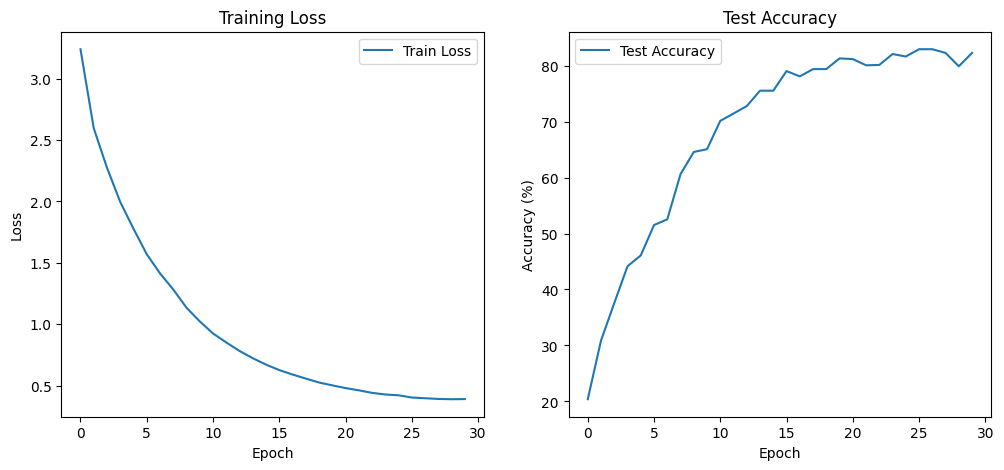

In [3]:


def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch}] Training")
    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        loop.set_postfix({"Loss": f"{loss.item():.4f}", "Acc": f"{100.*correct/total:.2f}%"})
    avg_loss = running_loss / len(train_loader)
    acc = 100.*correct/total
    train_losses.append(avg_loss)
    print(f"\nEpoch [{epoch}] | Train Loss: {avg_loss:.4f} | Train Acc: {acc:.2f}%")

def evaluate(epoch):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    loop = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch [{epoch}] Testing")
    with torch.no_grad():
        for batch_idx, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loop.set_postfix({"Acc": f"{100.*correct/total:.2f}%"})
    acc = 100.*correct/total
    test_accuracies.append(acc)
    print(f"\nTest Accuracy after Epoch [{epoch}]: {acc:.2f}%")
    return all_labels, all_preds


for epoch in range(1, num_epochs+1):
    train_one_epoch(epoch)
    labels, preds = evaluate(epoch)
    scheduler.step()

print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=trainset.classes))
print("\nConfusion Matrix:\n")
print(confusion_matrix(labels, preds))

torch.save(model.state_dict(), "efficientnetb0_cifar10.pth")
print("Model saved as efficientnetb0_cifar10.pth")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()
plt.show()